# **Data Import :**

In [ ]:
!pip install rasterio --quiet

import os
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 61.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WaterSeg_Data.zip to WaterSeg_Data.zip


In [ ]:
import zipfile
import os

# مسار الملف المضغوط (تأكد أنك رفعته)
zip_path = "/content/WaterSeg_Data.zip"
extract_dir = "/content/WaterSeg_Data"

# فك الضغط
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# التأكد من المحتويات
os.listdir(f"{extract_dir}/data")



['images', 'labels']

# **Preprocessing :**

In [ ]:
image_dir = "/content/WaterSeg_Data/data/images"
label_dir = "/content/WaterSeg_Data/data/labels"

# Shared file names
image_names = [f[:-4] for f in os.listdir(image_dir) if f.endswith(".tif")]
label_names = [f[:-4] for f in os.listdir(label_dir) if f.endswith(".png")]
common_names = sorted(list(set(image_names) & set(label_names)))

# Read .tif image (12 channels)
def read_tif_image(path):
    with rasterio.open(path) as img:
        arr = img.read()  # (channels, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # to (H, W, C)
        arr = cv2.resize(arr, (128, 128))
    return arr

# Read .png image
def read_label(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

image_paths = [os.path.join(image_dir, name + ".tif") for name in common_names]
label_paths = [os.path.join(label_dir, name + ".png") for name in common_names]

images = [read_tif_image(p) for p in image_paths]
labels = [read_label(p) for p in label_paths]

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.uint8)

print("X shape:", X.shape)  # (N, 128, 128, 12)
print("Y shape:", Y.shape)  # (N, 128, 128, 1)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)


X shape: (306, 128, 128, 12)
Y shape: (306, 128, 128, 1)
Train: (244, 128, 128, 12)
Test: (62, 128, 128, 12)


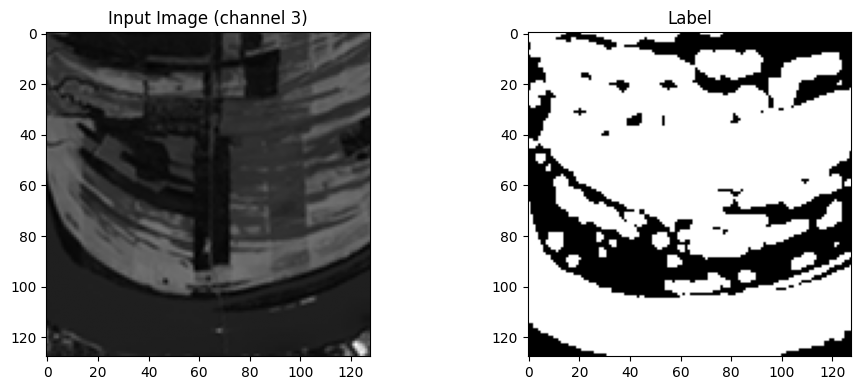

In [ ]:
image_dir = "/content/WaterSeg_Data/data/images"
label_dir = "/content/WaterSeg_Data/data/labels"

# Shared file names
image_names = [f[:-4] for f in os.listdir(image_dir) if f.endswith(".tif")]
label_names = [f[:-4] for f in os.listdir(label_dir) if f.endswith(".png")]
common_names = sorted(list(set(image_names) & set(label_names)))

# Read .tif image (12 channels)
def read_tif_image(path):
    with rasterio.open(path) as img:
        arr = img.read()  # (channels, H, W)
        arr = np.transpose(arr, (1, 2, 0))  # to (H, W, C)
        arr = cv2.resize(arr, (128, 128))
    return arr

# Read .png image
def read_label(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

image_paths = [os.path.join(image_dir, name + ".tif") for name in common_names]
label_paths = [os.path.join(label_dir, name + ".png") for name in common_names]

images = [read_tif_image(p) for p in image_paths]
labels = [read_label(p) for p in label_paths]

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.uint8)

print("X shape:", X.shape)  # (N, 128, 128, 12)
print("Y shape:", Y.shape)  # (N, 128, 128, 1)

# Normalization (channel-wise min-max)
X_min = np.min(X, axis=(0, 1, 2), keepdims=True)
X_max = np.max(X, axis=(0, 1, 2), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-8)

# Labels
Y = (Y > 0).astype(np.uint8)

# 80% Training - 20% Testing
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Train:", train_x.shape)
print("Test:", test_x.shape)

def show_sample(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(train_x[index][:,:,3], cmap='gray')
    axs[0].set_title("Input Image (channel 3)")

    label_img = train_y[index]
    if label_img.shape[-1] == 2:
        label_img = np.argmax(label_img, axis=-1)

    axs[1].imshow(label_img, cmap='gray')
    axs[1].set_title("Label")
    plt.tight_layout()
    plt.show()

show_sample(0)

In [ ]:
# Normalization (channel-wise min-max)
X_min = np.min(X, axis=(0, 1, 2), keepdims=True)
X_max = np.max(X, axis=(0, 1, 2), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-8)

# Labels
Y = (Y > 0).astype(np.uint8)


In [ ]:
# 80% Training - 20% Testing
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Train:", train_x.shape)
print("Test:", test_x.shape)


Train: (244, 128, 128, 12)
Test: (62, 128, 128, 12)


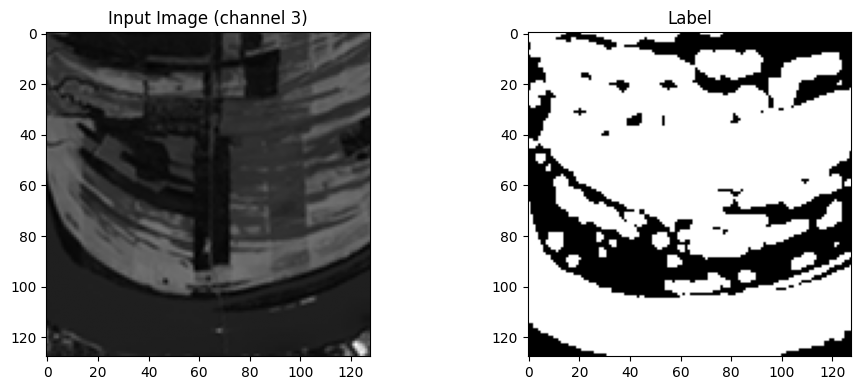

In [ ]:
def show_sample(index):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(train_x[index][:,:,3], cmap='gray')
    axs[0].set_title("Input Image (channel 3)")

    label_img = train_y[index]
    if label_img.shape[-1] == 2:
        label_img = np.argmax(label_img, axis=-1)

    axs[1].imshow(label_img, cmap='gray')
    axs[1].set_title("Label")
    plt.tight_layout()
    plt.show()

show_sample(0)


# **U-Net Model :**

In [ ]:
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, filters):
    x = layers.UpSampling2D((2, 2))(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    # Bridge
    b1 = conv_block(p3, 512)

    # Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d3) # A final Conv2D layer with (2 classes: water/background).

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_19[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_21[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 768)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_24[0][0] 

 Total params: 7,788,097 (29.71 MB)

 Trainable params: 7,788,097 (29.71 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping and reduce_lr & model checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

checkpoint = ModelCheckpoint("best_model_scratch.h5", monitor="val_accuracy", save_best_only=True)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])


history = model.fit(
    train_x, train_y,
    epochs=80,
    batch_size=8
)


Epoch 1/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 562ms/step - accuracy: 0.7164 - loss: 0.6097
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.8618 - loss: 0.3756
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8898 - loss: 0.3073
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8863 - loss: 0.3110
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8898 - loss: 0.2961
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9121 - loss: 0.2464
Epoch 7/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8936 - loss: 0.2917
Epoch 8/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9089 - loss: 0.2465
Epoch 9/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9156 - loss: 0.2247
Epoch 10/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9055 - loss: 0.2448
Epoch 11/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9098 - loss: 0.2401
Epoch 12/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/ste

In [ ]:
loss, acc = model.evaluate(train_x, train_y)
print("Train accuracy:", acc)

loss, acc = model.evaluate(test_x, test_y)
print("Test accuracy:", acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9840 - loss: 0.0395
Train accuracy: 0.9841681122779846
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9690 - loss: 0.1025
Test accuracy: 0.9669691324234009


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


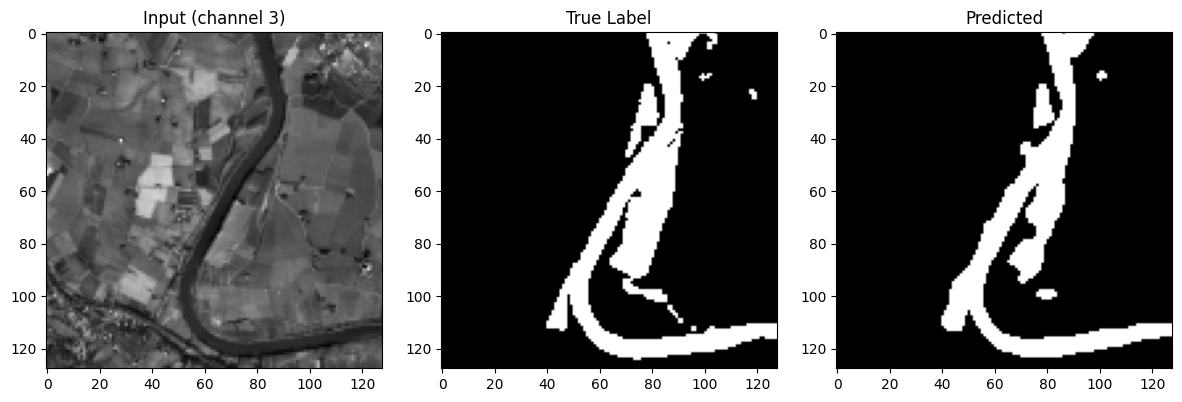

In [ ]:
def show_prediction(index):
    image = test_x[index:index+1]  # (1, 128, 128, 12)

    # True label
    label = test_y[index].squeeze()  # (128, 128)

    # Prediction
    pred = model.predict(image)[0]  # (128, 128, 1)
    pred = (pred > 0.5).astype(np.uint8).squeeze()  # Threshold + remove channel dim

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[0][:,:,3], cmap='gray')  # Channel 3 فقط
    axs[0].set_title("Input (channel 3)")
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title("True Label")
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title("Predicted")
    plt.tight_layout()
    plt.show()

show_prediction(0)


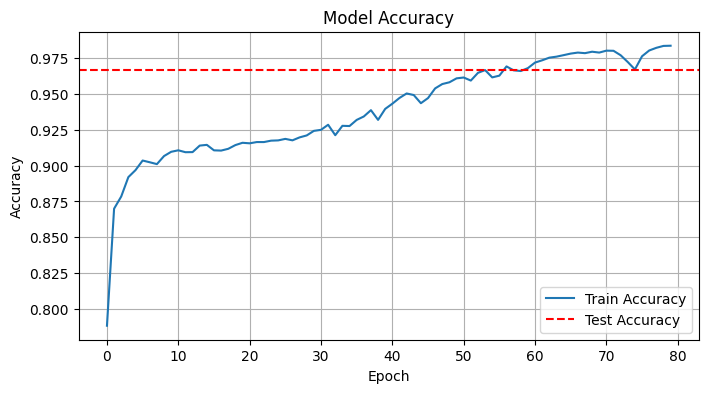

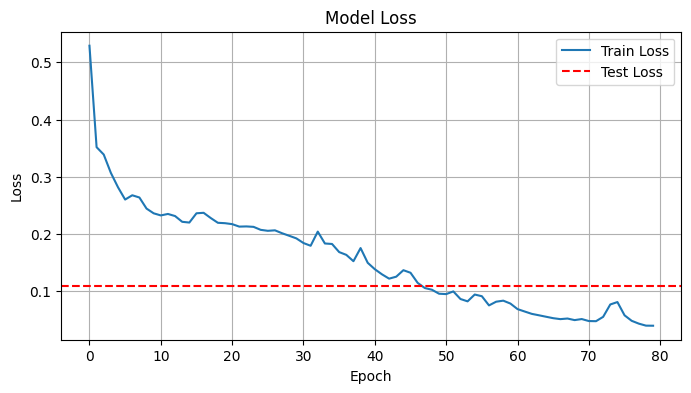

Train Accuracy: 0.9841681122779846
Test Accuracy: 0.9669691324234009
Train Loss: 0.03872649371623993
Test Loss: 0.11010701209306717


In [ ]:
train_loss, train_acc = model.evaluate(train_x, train_y, verbose=0)
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)

# 1. Accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2. Loss plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print values for confirmation
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

#1. Probabilistic Forecasts
y_pred_probs = model.predict(test_x)  # shape = (N, H, W, 1)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)  # تحويل إلى 0 أو 1 باستخدام threshold 0.5

# 2. Ground truth
y_true = test_y.astype(np.uint8)  # يفترض أنه بالفعل 0 أو 1

#3. Flatten to 1D to compare each pixel.
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

#4. Evaluation Reports
print("\nClassification Report:\n", classification_report(y_true_flat, y_pred_flat, digits=4))

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
accuracy = accuracy_score(y_true_flat, y_pred_flat)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

Classification Report:
               precision    recall  f1-score   support

           0     0.9740    0.9836    0.9788    787894
           1     0.9414    0.9094    0.9251    227914

    accuracy                         0.9670   1015808
   macro avg     0.9577    0.9465    0.9520   1015808
weighted avg     0.9667    0.9670    0.9668   1015808

Accuracy:  0.9670
Precision: 0.9414
Recall:    0.9094
F1 Score:  0.9251


In [ ]:
import numpy as np

# A function to calculate the IoU between predicted and actual pixels
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0  # Special case if both are empty

    iou = intersection / union
    return iou

# Predict the model
y_pred_probs = model.predict(test_x)                      # Output: (N, H, W, 1)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)            # Apply threshold to get binary mask

# Ground truth
y_true = test_y.astype(np.uint8)                          # Already binary (0 or 1)

# Flatten the results to 1D
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Calculate IoU
iou_score = compute_iou(y_true_flat, y_pred_flat)
print(f"IoU: {iou_score:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
IoU: 0.8607


# **U-Net with "Dice"**

In [ ]:
import tensorflow as tf
import numpy as np

# 1. تعريف Dice Loss و Dice Coefficient
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


# 3. تجميع الموديل باستخدام Dice Loss و Dice Coefficient
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy', dice_coef]
)

# 4. تدريب الموديل
history = model.fit(train_x, train_y, epochs=80, batch_size=8)

#Evaluation
loss, acc, dice = model.evaluate(train_x, train_y)
print("Train Accuracy:", acc)
print("Train Dice Score:", dice)

loss, acc, dice = model.evaluate(test_x, test_y)
print("Test Accuracy:", acc)
print("Test Dice Score:", dice)


#حساب Dice Score بعد التنبؤ (Numpy Version)
import numpy as np

def dice_score_np(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    total = np.sum(y_true) + np.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (total + smooth)
    return dice

y_pred_probs = model.predict(test_x)
y_pred = np.argmax(y_pred_probs, axis=-1)
y_true = np.argmax(test_y, axis=-1)

dice = dice_score_np(y_true.flatten(), y_pred.flatten())
print(f"Dice Score (Numpy): {dice:.4f}")


# **Pre-trained model :  (Preprocessing)**

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_on_images(images, n_components=3):
    """
    Apply PCA to reduce channels from 12 to 3 on a batch of images.

    Parameters:
    - images: numpy array of shape (num_samples, height, width, 12)
    - n_components: number of channels after reduction

    Returns:
    - reduced_images: numpy array of shape (num_samples, height, width, n_components)
    """
    num_samples, height, width, channels = images.shape
    reduced_images = np.zeros((num_samples, height, width, n_components), dtype=np.float32)

    for i in range(num_samples):
        # reshape from (128,128,12) → (128*128, 12)
        flat_img = images[i].reshape(-1, channels)

        # apply PCA on pixel vectors
        pca = PCA(n_components=n_components)
        flat_reduced = pca.fit_transform(flat_img)

        # reshape back to (128,128,n_components)
        reduced_images[i] = flat_reduced.reshape(height, width, n_components)

    return reduced_images


In [ ]:
# نفترض أن train_x هو (N, 128, 128, 12)
train_x_rgb = apply_pca_on_images(train_x, n_components=3)

# نفس الشيء إذا عندك test set
test_x_rgb = apply_pca_on_images(test_x, n_components=3)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    return 1 - dice


# **Pre-trained model :  (Model Building & Training)**

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def build_model_with_resnet3(input_shape=(128, 128, 3)):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Skip connections
    inputs = base_model.input
    skip1 = base_model.get_layer("conv1_relu").output        # 64x64
    skip2 = base_model.get_layer("conv2_block3_out").output  # 32x32
    skip3 = base_model.get_layer("conv3_block4_out").output  # 16x16
    encoder_output = base_model.get_layer("conv4_block6_out").output  # 8x8

    # Decoder
    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding="same", activation='relu')(encoder_output)
    d1 = layers.Concatenate()([d1, skip3])
    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation='relu')(d1)
    d2 = layers.Concatenate()([d2, skip2])
    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation='relu')(d2)
    d3 = layers.Concatenate()([d3, skip1])
    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation='relu')(d3)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    return model

model = build_model_with_resnet3(input_shape=(128,128,3))
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 16,368,513 (62.44 MB)

 Trainable params: 16,337,921 (62.32 MB)

 Non-trainable params: 30,592 (119.50 KB)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.7436 - loss: 0.5970

31/31 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7448 - loss: 0.5951 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8301 - loss: 0.4069

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.8297 - loss: 0.4074 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7924 - loss: 0.4376

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7931 - loss: 0.4366 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8405 - loss: 0.3767

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8400 - loss: 0.3774 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8002 - loss: 0.4460

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.8008 - loss: 0.4445 - learning_rate: 0.0010
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8376 - loss: 0.3685

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8372 - loss: 0.3690 - learning_rate: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8092 - loss: 0.4052 - learning_rate: 0.0010
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8272 - loss: 0.3598

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8274 - loss: 0.3601 - learning_rate: 0.0010
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8526 - loss: 0.3239

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.8522 - loss: 0.3247 - learning_rate: 0.0010
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8511 - loss: 0.3435 - learning_rate: 0.0010
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8604 - loss: 0.3162

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8603 - loss: 0.3164 - learning_rate: 0.0010
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8540 - loss: 0.3299

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8540 - loss: 0.3296 - learning_rate: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8805 - loss: 0.2725

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8806 - loss: 0.2721 - learning_rate: 0.0010
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8735 - loss: 0.2809 - learning_rate: 0.0010
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8821 - loss: 0.2635

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8823 - loss: 0.2632 - learning_rate: 0.0010
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8962 - loss: 0.2444 - learning_rate: 0.0010
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9018 - loss: 0.2324 - learning_rate: 0.0010
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8989 - loss: 0.2602 - learning_rate: 0.0010
Epoch 19/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8907 - loss: 0.2562

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8909 - loss: 0.2558 - learning_rate: 0.0010
Epoch 20/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9082 - loss: 0.2219

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9084 - loss: 0.2213 - learning_rate: 0.0010
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9209 - loss: 0.1887

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9207 - loss: 0.1891 - learning_rate: 0.0010
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9057 - loss: 0.2392 - learning_rate: 0.0010
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9306 - loss: 0.1693

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9307 - loss: 0.1694 - learning_rate: 0.0010
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9293 - loss: 0.1734

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9295 - loss: 0.1731 - learning_rate: 0.0010
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9464 - loss: 0.1359

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9463 - loss: 0.1361 - learning_rate: 0.0010
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9416 - loss: 0.1471 - learning_rate: 0.0010
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9337 - loss: 0.1650 - learning_rate: 0.0010
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9324 - loss: 0.1705 - learning_rate: 0.0010
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9411 - loss: 0.1489 - learning_rate: 0.0010
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9499 - loss: 0.1293

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9500 - loss: 0.1291 - learning_rate: 0.0010
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9507 - loss: 0.1252

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9507 - loss: 0.1250 - learning_rate: 0.0010
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9549 - loss: 0.1148 - learning_rate: 0.0010
Epoch 33/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9566 - loss: 0.1080

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9566 - loss: 0.1082 - learning_rate: 0.0010
Epoch 34/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9586 - loss: 0.1045

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9586 - loss: 0.1044 - learning_rate: 0.0010
Epoch 35/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9611 - loss: 0.0962

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9611 - loss: 0.0963 - learning_rate: 0.0010
Epoch 36/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9600 - loss: 0.0988

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9601 - loss: 0.0985 - learning_rate: 0.0010
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9580 - loss: 0.1058 - learning_rate: 0.0010
Epoch 38/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9670 - loss: 0.0827

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9668 - loss: 0.0831 - learning_rate: 0.0010
Epoch 39/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9666 - loss: 0.0819

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9664 - loss: 0.0824 - learning_rate: 0.0010
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9415 - loss: 0.1425 - learning_rate: 0.0010
Epoch 41/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9535 - loss: 0.1160 - learning_rate: 0.0010
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9575 - loss: 0.1059 - learning_rate: 0.0010
Epoch 43/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9611 - loss: 0.0973 - learning_rate: 0.0010
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9699 - loss: 0.0757

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9699 - loss: 0.0758 - learning_rate: 0.0010
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9694 - loss: 0.0761

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9694 - loss: 0.0759 - learning_rate: 0.0010
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9708 - loss: 0.0725

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9708 - loss: 0.0723 - learning_rate: 0.0010
Epoch 47/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9747 - loss: 0.0629

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9747 - loss: 0.0631 - learning_rate: 0.0010
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9748 - loss: 0.0626

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9748 - loss: 0.0627 - learning_rate: 0.0010
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9734 - loss: 0.0666 - learning_rate: 0.0010
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9746 - loss: 0.0633

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9746 - loss: 0.0633 - learning_rate: 0.0010


In [ ]:
# تقييم الأداء على بيانات التدريب
train_loss, train_acc = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", round(train_acc * 100, 2), "%")
print("Train Loss:", round(train_loss, 4))

# تقييم الأداء على بيانات الاختبار
test_loss, test_acc = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", round(test_acc * 100, 2), "%")
print("Test Loss:", round(test_loss, 4))


8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 982ms/step - accuracy: 0.9755 - loss: 0.0599
Train Accuracy: 97.55 %
Train Loss: 0.0597
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.9083 - loss: 0.3007
Test Accuracy: 90.3 %
Test Loss: 0.3209


In [ ]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])


history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9594 - loss: 0.2079

31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 642ms/step - accuracy: 0.9593 - loss: 0.2083 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9552 - loss: 0.2358 - learning_rate: 0.0010
Epoch 3/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9559 - loss: 0.2259

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9561 - loss: 0.2250 - learning_rate: 0.0010
Epoch 4/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9662 - loss: 0.1973

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9661 - loss: 0.1970 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9631 - loss: 0.2032 - learning_rate: 0.0010
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9617 - loss: 0.2000 - learning_rate: 0.0010
Epoch 7/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9598 - loss: 0.2026

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9602 - loss: 0.2017 - learning_rate: 0.0010
Epoch 8/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9653 - loss: 0.1983

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9654 - loss: 0.1970 - learning_rate: 0.0010
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9665 - loss: 0.1760 - learning_rate: 0.0010
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9621 - loss: 0.2247 - learning_rate: 0.0010
Epoch 11/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9676 - loss: 0.1702

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9676 - loss: 0.1701 - learning_rate: 0.0010
Epoch 12/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9698 - loss: 0.1561

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9699 - loss: 0.1564 - learning_rate: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9402 - loss: 0.3349 - learning_rate: 0.0010
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9528 - loss: 0.2432 - learning_rate: 0.0010
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9642 - loss: 0.1855 - learning_rate: 0.0010
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9708 - loss: 0.1673 - learning_rate: 0.0010
Epoch 17/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9730 - loss: 0.1404

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9730 - loss: 0.1407 - learning_rate: 0.0010
Epoch 18/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9746 - loss: 0.1323

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9745 - loss: 0.1328 - learning_rate: 0.0010
Epoch 19/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9748 - loss: 0.1304

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9748 - loss: 0.1303 - learning_rate: 0.0010
Epoch 20/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9765 - loss: 0.1314

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9765 - loss: 0.1312 - learning_rate: 0.0010
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9797 - loss: 0.1153 - learning_rate: 0.0010
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9773 - loss: 0.1246 - learning_rate: 0.0010
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9698 - loss: 0.1658 - learning_rate: 0.0010
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9757 - loss: 0.1341 - learning_rate: 0.0010
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9777 - loss: 0.1214

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9777 - loss: 0.1212 - learning_rate: 0.0010
Epoch 26/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9837 - loss: 0.0995

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9836 - loss: 0.0996 - learning_rate: 0.0010
Epoch 27/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9809 - loss: 0.0975

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9810 - loss: 0.0976 - learning_rate: 0.0010
Epoch 28/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9828 - loss: 0.0909

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9828 - loss: 0.0911 - learning_rate: 0.0010
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9822 - loss: 0.1077 - learning_rate: 0.0010
Epoch 30/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9844 - loss: 0.0858

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9844 - loss: 0.0857 - learning_rate: 0.0010
Epoch 31/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9856 - loss: 0.0782

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9855 - loss: 0.0783 - learning_rate: 0.0010
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9824 - loss: 0.1049 - learning_rate: 0.0010
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9860 - loss: 0.0752 - learning_rate: 0.0010
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9855 - loss: 0.0865 - learning_rate: 0.0010
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9847 - loss: 0.0903 - learning_rate: 0.0010
Epoch 36/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9848 - loss: 0.0809

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9849 - loss: 0.0807 - learning_rate: 0.0010
Epoch 37/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9857 - loss: 0.0758

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9858 - loss: 0.0758 - learning_rate: 0.0010
Epoch 38/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9856 - loss: 0.0749

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9857 - loss: 0.0747 - learning_rate: 0.0010
Epoch 39/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9872 - loss: 0.0679

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9872 - loss: 0.0678 - learning_rate: 0.0010
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9876 - loss: 0.0698 - learning_rate: 0.0010
Epoch 41/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9895 - loss: 0.0567

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9895 - loss: 0.0571 - learning_rate: 0.0010
Epoch 42/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9873 - loss: 0.0695

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9874 - loss: 0.0690 - learning_rate: 0.0010
Epoch 43/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9893 - loss: 0.0604

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9893 - loss: 0.0605 - learning_rate: 0.0010
Epoch 44/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9908 - loss: 0.0486

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9907 - loss: 0.0490 - learning_rate: 0.0010
Epoch 45/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9915 - loss: 0.0497

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.9914 - loss: 0.0499 - learning_rate: 0.0010
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9907 - loss: 0.0549 - learning_rate: 0.0010
Epoch 47/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9875 - loss: 0.0684 - learning_rate: 0.0010
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9809 - loss: 0.0995 - learning_rate: 0.0010
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9278 - loss: 0.4563 - learning_rate: 0.0010
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9126 - loss: 0.4360 - learning_rate: 0.0010


In [ ]:
loss, acc = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", acc)

loss, acc = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - accuracy: 0.9918 - loss: 0.0454
Train Accuracy: 0.9918603301048279
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9316 - loss: 0.5541
Test Accuracy: 0.926734209060669


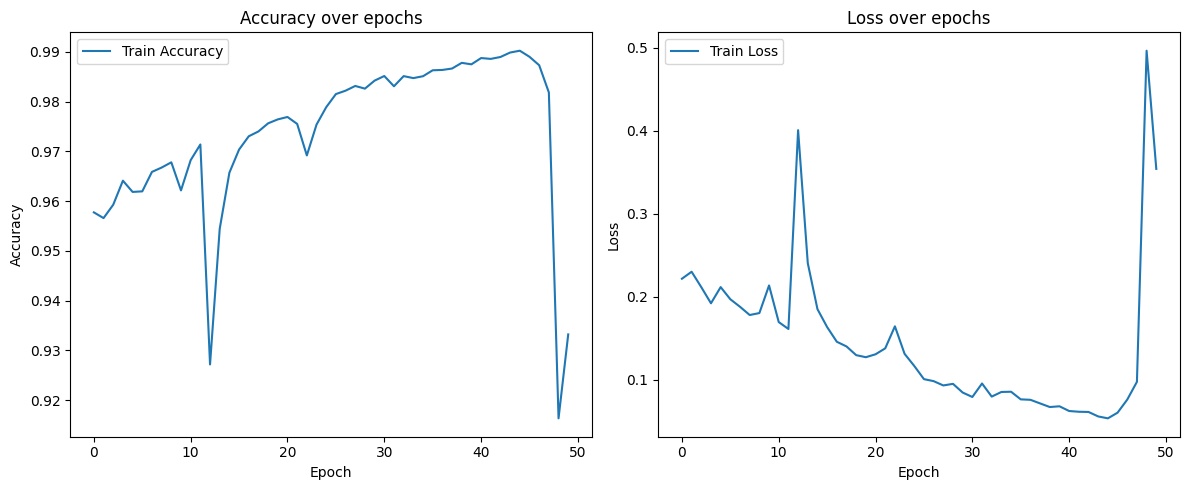

In [ ]:
import matplotlib.pyplot as plt

# رسم منحنى الدقة
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم منحنى الخسارة
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# **TRAINING WITH IoU**

In [ ]:
import tensorflow as tf

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    y_pred_f = tf.round(y_pred_f)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou

model.compile(
    optimizer='adam',
    loss=dice_loss,  # أو binary_crossentropy
    metrics=['accuracy', iou_metric]
)

history = model.fit(
    train_x_rgb, train_y,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5),
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
    ]
)

loss, acc = model.evaluate(train_x_rgb, train_y)
print("Train Accuracy:", acc)

loss, acc = model.evaluate(test_x_rgb, test_y)
print("Test Accuracy:", acc)


# توقع على بيانات الاختبار
y_pred = model.predict(test_x_rgb)
y_pred = (y_pred > 0.5).astype("float32")  # تحويل النتائج إلى ثنائية

# حساب IoU
def compute_iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

iou_score = compute_iou(test_y, y_pred)
print("IoU Score on Test Data:", iou_score.numpy())


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9868 - iou_metric: 0.9516 - loss: 0.0283

31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 644ms/step - accuracy: 0.9867 - iou_metric: 0.9511 - loss: 0.0286 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9844 - iou_metric: 0.9342 - loss: 0.0361 - learning_rate: 0.0010
Epoch 3/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9876 - iou_metric: 0.9477 - loss: 0.0285

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9876 - iou_metric: 0.9477 - loss: 0.0284 - learning_rate: 0.0010
Epoch 4/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9879 - iou_metric: 0.9534 - loss: 0.0253

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9879 - iou_metric: 0.9533 - loss: 0.0254 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9890 - iou_metric: 0.9573 - loss: 0.0231

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9890 - iou_metric: 0.9573 - loss: 0.0231 - learning_rate: 0.0010
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9888 - iou_metric: 0.9501 - loss: 0.0266 - learning_rate: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9820 - iou_metric: 0.9229 - loss: 0.0414 - learning_rate: 0.0010
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9822 - iou_metric: 0.9317 - loss: 0.0365 - learning_rate: 0.0010
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9843 - iou_metric: 0.9464 - loss: 0.0284 - learning_rate: 0.0010
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9894 - iou_metric: 0.9531 - loss: 0.0251 - learning_rate: 0.0010
Epoch 11/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9889 - iou_metric: 0.9596 - loss: 0.0214

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9889 - iou_metric: 0.9593 - loss: 0.0215 - learning_rate: 5.0000e-04
Epoch 12/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9917 - iou_metric: 0.9574 - loss: 0.0228

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9916 - iou_metric: 0.9576 - loss: 0.0226 - learning_rate: 5.0000e-04
Epoch 13/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9916 - iou_metric: 0.9673 - loss: 0.0174

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9916 - iou_metric: 0.9673 - loss: 0.0174 - learning_rate: 5.0000e-04
Epoch 14/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9921 - iou_metric: 0.9692 - loss: 0.0165

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9921 - iou_metric: 0.9692 - loss: 0.0165 - learning_rate: 5.0000e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9925 - iou_metric: 0.9676 - loss: 0.0175 - learning_rate: 5.0000e-04
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9921 - iou_metric: 0.9706 - loss: 0.0158 - learning_rate: 5.0000e-04
Epoch 17/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9931 - iou_metric: 0.9737 - loss: 0.0141

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9930 - iou_metric: 0.9735 - loss: 0.0142 - learning_rate: 5.0000e-04
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9935 - iou_metric: 0.9733 - loss: 0.0144 - learning_rate: 5.0000e-04
Epoch 19/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9929 - iou_metric: 0.9724 - loss: 0.0148

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9929 - iou_metric: 0.9724 - loss: 0.0148 - learning_rate: 5.0000e-04
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9936 - iou_metric: 0.9748 - loss: 0.0135

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9935 - iou_metric: 0.9747 - loss: 0.0135 - learning_rate: 5.0000e-04
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9943 - iou_metric: 0.9757 - loss: 0.0130 - learning_rate: 5.0000e-04
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9927 - iou_metric: 0.9652 - loss: 0.0188 - learning_rate: 5.0000e-04
Epoch 23/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9932 - iou_metric: 0.9742 - loss: 0.0137

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9932 - iou_metric: 0.9741 - loss: 0.0138 - learning_rate: 5.0000e-04
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9940 - iou_metric: 0.9773 - loss: 0.0121

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9939 - iou_metric: 0.9773 - loss: 0.0122 - learning_rate: 5.0000e-04
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9938 - iou_metric: 0.9759 - loss: 0.0128 - learning_rate: 5.0000e-04
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9927 - iou_metric: 0.9728 - loss: 0.0145 - learning_rate: 5.0000e-04
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9923 - iou_metric: 0.9670 - loss: 0.0179 - learning_rate: 5.0000e-04
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9850 - iou_metric: 0.9431 - loss: 0.0299 - learning_rate: 5.0000e-04
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9924 - iou_metric: 0.9692 - loss: 0.0163 - learning_rate: 5.0000e-04
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9928 - iou_metric: 0.9700 - loss: 0.0160 - learning_rate: 2.5000e-04
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9949 - iou_metric: 0.9794 - loss: 0.0110 - learning_rate: 2.5000e-04
Epoch 33/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9942 - iou_metric: 0.9770 - loss: 0.0123

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9942 - iou_metric: 0.9770 - loss: 0.0123 - learning_rate: 2.5000e-04
Epoch 34/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9944 - iou_metric: 0.9805 - loss: 0.0105

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9944 - iou_metric: 0.9804 - loss: 0.0105 - learning_rate: 2.5000e-04
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9956 - iou_metric: 0.9789 - loss: 0.0115 - learning_rate: 2.5000e-04
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9953 - iou_metric: 0.9780 - loss: 0.0118 - learning_rate: 2.5000e-04
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9934 - iou_metric: 0.9688 - loss: 0.0168 - learning_rate: 2.5000e-04
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9924 - iou_metric: 0.9741 - loss: 0.0138 - learning_rate: 2.5000e-04
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9942 - iou_metric: 0.9768 - loss: 0.0124 - learning_rate: 2.5000e-04
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9947 - iou_metric: 0.9759 - loss: 0.0129 - learning_rate: 1.2500e-04
Epoch 41/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.

ValueError: too many values to unpack (expected 2)